# The Open University / Space Science course S818 / TMA01 Question n°1.b
Student : Madeline Pennerath

This Jupyter notebook produces a graph of integrated proton flux above 10MeV as a function of time and for a month to show if a Solar Radiation Storm event occurred. The calculations use data from a GOES satellite that are taken from the National Oceanic and Atmospheric Administration's (NOAA) website (see links below).

In [1]:
# this code conceals irrelevant warning messages
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [2]:
# routines:
from pandas import *
from numpy import  *
%matplotlib inline

In [3]:
# variables:
# 1. Date at which the data is taken. For this activity, the chosen month will be within the last 36 months before March 5th, 2020.
# please indicate your chosen year (format YYYY)
YYYY = 2014
# please indicate your chosen month (for example for january type "1")
MM = 1
# 2. please choose the name of the satellite (GOES-NN) where the data below will come from. For this activity, NN should be either 14 or 15 (warning: not all of them are available every month)
NN = 15
MMf = str(MM).zfill(2) # new variable to add a leading zero if the month has only one number, so that it works with the website link below

In [4]:
# determining the number of days in the month to be able to retrieve the data
if ((MM%2 != 0) and (MM >=1) and (MM <=12)):
    DD = 31
elif ((MM%2 == 0) and (MM >=1) and (MM <=12)):
    DD = 30
elif (MM == 2):
    if (( YYYY%400 == 0)or (( YYYY%4 == 0 ) and ( YYYY%100 != 0))): #if it is a leap year
        DD = 29
    else : #if it is not a leap year
        DD = 28
else:
    DD = 0
    print('error in value of MM') # if the month is not well indicated above

In [5]:
# loading the data from the NOAA website into the notebook
EPEAD='https://satdat.ngdc.noaa.gov/sem/goes/data/avg/'+str(YYYY)+'/'+MMf+'/goes'+str(NN)+'/csv/g'+str(NN)+'_epead_p17ew_5m_'+str(YYYY)+MMf+'01_'+str(YYYY)+MMf+str(DD)+'.csv'
HEPAD ='http://satdat.ngdc.noaa.gov/sem/goes/data/avg/'+str(YYYY)+'/'+str(MMf)+'/goes'+str(NN)+'/csv/g'+str(NN)+'_hepad_ap_5m_'+str(YYYY)+str(MMf)+'01_'+str(YYYY)+str(MMf)+str(DD)+'.csv'

# creating new variables for the dataframes headers
nEhead = 672 + int(DD)
if ((YYYY < 2019) or (YYYY == 2019) and (MM < 9)): # the header row changed in September 2019
    nHhead =254 + int(DD)
else:
    nHhead = 250 + int(DD)

In [6]:
# creating dataframes to store the data
dfE=read_csv(EPEAD, header=nEhead)
dfH = read_csv(HEPAD,header=nHhead)

In [7]:
# converting the "time_tag" columns into datetime64 format
dfE['time_tag'] = to_datetime(dfE['time_tag'])
dfH['time_tag'] = to_datetime(dfH['time_tag'])

In [8]:
# adding up the quality flags to keep only the rows where all the quality flags for the data considered are zero
dfE['TOT_QUALE'] = dfE['P3E_QUAL_FLAG']+dfE['P4E_QUAL_FLAG']+dfE['P5E_QUAL_FLAG']+dfE['P6E_QUAL_FLAG']+dfE['P7E_QUAL_FLAG']
dfE['TOT_QUALW'] = dfE['P3W_QUAL_FLAG']+dfE['P4W_QUAL_FLAG']+dfE['P5W_QUAL_FLAG']+dfE['P6W_QUAL_FLAG']+dfE['P7W_QUAL_FLAG']
dfE['TOT_QUAL'] = dfE['TOT_QUALE']+dfE['TOT_QUALW']
dfE = dfE[dfE.TOT_QUAL == 0]
dfH['TOT_QUAL'] = dfH['P8_QUAL_FLAG']+dfH['P9_QUAL_FLAG']+dfH['P10_QUAL_FLAG']+dfH['P11_QUAL_FLAG']
dfH = dfH[dfH.TOT_QUAL == 0]

In [9]:
# averaging the East and West corrected fluxes for the P2 to P7 proton channels
dfE['P2_FLUX']=(dfE['P2E_COR_FLUX']+dfE['P2W_COR_FLUX'])/2
dfE['P3_FLUX']=(dfE['P3E_COR_FLUX']+dfE['P3W_COR_FLUX'])/2
dfE['P4_FLUX']=(dfE['P4E_COR_FLUX']+dfE['P4W_COR_FLUX'])/2
dfE['P5_FLUX']=(dfE['P5E_COR_FLUX']+dfE['P5W_COR_FLUX'])/2
dfE['P6_FLUX']=(dfE['P6E_COR_FLUX']+dfE['P6W_COR_FLUX'])/2
dfE['P7_FLUX']=(dfE['P7E_COR_FLUX']+dfE['P7W_COR_FLUX'])/2
headings = ['time_tag', 'P2_FLUX', 'P3_FLUX', 'P4_FLUX', 'P5_FLUX','P6_FLUX', 'P7_FLUX'] 
dfE = dfE[headings] # keeping only the mentioned columns in the dataframe
headings = ['time_tag', 'P8_FLUX', 'P9_FLUX', 'P10_FLUX', 'P11_FLUX']
dfH = dfH[headings]

In [10]:
# merging both dataframes into one using the dates as reference
dfEH = merge(dfE, dfH, on='time_tag', how='inner')

In [11]:
# calculating the effective energy of each proton channel as the geometric mean of the channel boundary energies
E2 = (4.2*8.7)**0.5 # [MeV]
E3 = (8.7*14.5)**0.5
E4 = (15*40)**0.5
E5 = (38*82)**0.5
E6 = (84*200)**0.5
E7 = (110*900)**0.5
E8 = (330*420)**0.5
E9 = (420*510)**0.5
E10 = (510*700)**0.5
E11 = 1000.0 # approximation

In [12]:
# obtaining values for normalisations A and slopes alpha between each pair of energy values using a piece-wise power law
dfEH['alpha_23'] = (log10(dfEH['P3_FLUX'])-log10(dfEH['P2_FLUX'])) / (log10(E3)-log10(E2))
dfEH['A_23'] = 10.0**(log10(dfEH['P2_FLUX'])-(dfEH['alpha_23']*log10(E2)))
dfEH['alpha_34'] = (log10(dfEH['P4_FLUX'])-log10(dfEH['P3_FLUX'])) / (log10(E4)-log10(E3))
dfEH['A_34'] = 10.0**(log10(dfEH['P3_FLUX'])-(dfEH['alpha_34']*log10(E3)))
dfEH['alpha_45'] = (log10(dfEH['P5_FLUX'])-log10(dfEH['P4_FLUX'])) / (log10(E5)-log10(E4))
dfEH['A_45'] = 10.0**(log10(dfEH['P4_FLUX'])-(dfEH['alpha_45']*log10(E4)))
dfEH['alpha_56'] = (log10(dfEH['P6_FLUX'])-log10(dfEH['P5_FLUX'])) / (log10(E6)-log10(E5))
dfEH['A_56'] = 10.0**(log10(dfEH['P5_FLUX'])-(dfEH['alpha_56']*log10(E5)))
dfEH['alpha_67'] = (log10(dfEH['P7_FLUX'])-log10(dfEH['P6_FLUX'])) / (log10(E7)-log10(E6))
dfEH['A_67'] = 10.0**(log10(dfEH['P6_FLUX'])-(dfEH['alpha_67']*log10(E6)))
dfEH['alpha_78'] = (log10(dfEH['P8_FLUX'])-log10(dfEH['P7_FLUX'])) / (log10(E8)-log10(E7))
dfEH['A_78'] = 10.0**(log10(dfEH['P7_FLUX'])-(dfEH['alpha_78']*log10(E7)))
dfEH['alpha_89'] = (log10(dfEH['P9_FLUX'])-log10(dfEH['P8_FLUX'])) / (log10(E9)-log10(E8))
dfEH['A_89'] = 10.0**(log10(dfEH['P8_FLUX'])-(dfEH['alpha_89']*log10(E8)))
dfEH['alpha_910'] = (log10(dfEH['P10_FLUX'])-log10(dfEH['P9_FLUX'])) / (log10(E10)-log10(E9))
dfEH['A_910'] = 10.0**(log10(dfEH['P9_FLUX'])-(dfEH['alpha_910']*log10(E9)))
dfEH['alpha_1011'] = (log10(dfEH['P11_FLUX'])-log10(dfEH['P10_FLUX'])) / (log10(E11)-log10(E10))
dfEH['A_1011'] = 10.0**(log10(dfEH['P10_FLUX'])-(dfEH['alpha_1011']*log10(E10)))

In [13]:
# calculating the integral flux between consecutive effective energies
dfEH['totflux_23'] = (dfEH['A_23']/(dfEH['alpha_23']+1))*(E3**(dfEH['alpha_23']+1)-10**(dfEH['alpha_23']+1))
dfEH['totflux_34'] = (dfEH['A_34']/(dfEH['alpha_34']+1))*(E4**(dfEH['alpha_34']+1)-E3**(dfEH['alpha_34']+1))
dfEH['totflux_45'] = (dfEH['A_45']/(dfEH['alpha_45']+1))*(E5**(dfEH['alpha_45']+1)-E4**(dfEH['alpha_45']+1))
dfEH['totflux_56'] = (dfEH['A_56']/(dfEH['alpha_56']+1))*(E6**(dfEH['alpha_56']+1)-E5**(dfEH['alpha_56']+1))
dfEH['totflux_67'] = (dfEH['A_67']/(dfEH['alpha_67']+1))*(E7**(dfEH['alpha_67']+1)-E6**(dfEH['alpha_67']+1))
dfEH['totflux_78'] = (dfEH['A_78']/(dfEH['alpha_78']+1))*(E8**(dfEH['alpha_78']+1)-E7**(dfEH['alpha_78']+1))
dfEH['totflux_89'] = (dfEH['A_89']/(dfEH['alpha_89']+1))*(E9**(dfEH['alpha_89']+1)-E8**(dfEH['alpha_89']+1))
dfEH['totflux_910'] = (dfEH['A_910']/(dfEH['alpha_910']+1))*(E10**(dfEH['alpha_910']+1)-E9**(dfEH['alpha_910']+1))
dfEH['totflux_1011'] = (dfEH['A_1011']/(dfEH['alpha_1011']+1))*(E11**(dfEH['alpha_1011']+1)-E10**(dfEH['alpha_1011']+1))

In [14]:
# summing the channel integrated fluxes to determine the total integrated flux in each time sample in proton flux unit [protons/cm2/sec/ster]
dfEH['totflux'] = dfEH['totflux_23']+dfEH['totflux_34']+dfEH['totflux_45']+dfEH['totflux_56']+dfEH['totflux_67']+dfEH['totflux_78']+dfEH['totflux_89']+dfEH['totflux_910']+dfEH['totflux_1011']
dfEH['storm'] = (log10(dfEH['totflux'])).apply(floor)

In [15]:
maxrow=dfEH['totflux'].idxmax() 
maxflux=int(dfEH['totflux'].iloc[maxrow]) # identify the maximum proton flux >10MeV for the month considered in proton flux unit [protons/cm2/sec/ster]
maxtime = dfEH['time_tag'].iloc[maxrow] # identify when exactly the max flux occurred
maxstorm = int(dfEH['storm'].iloc[maxrow]) # categorize the Solar Radiation Storm on a scale from (S)1 to (S)5 (or 0 if there is none)

Looking at January 2014, the maximum proton flux happened on Wednesday, January 08 at 14:10 and reached a radiation storm 
level S2 with a maximum flux of 755pfu.


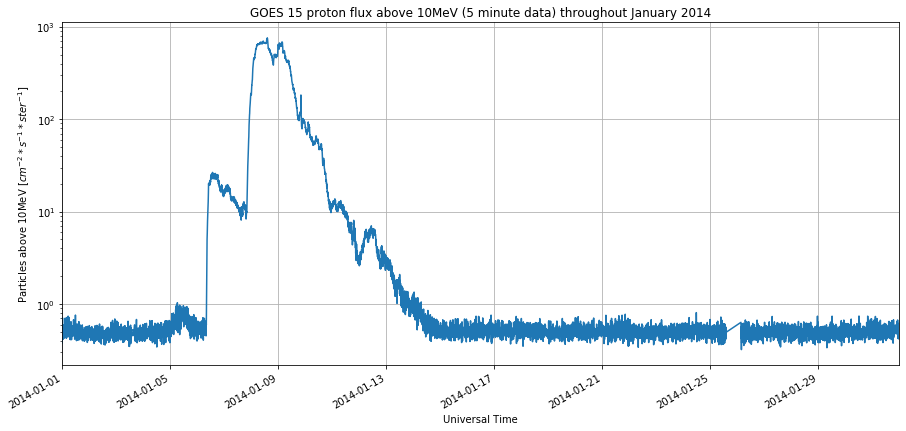

In [16]:
# plotting a graph of a specific size, log scale for the flux axis and labelling its axis
dfEH.set_index(['time_tag'],inplace=True)
ax = dfEH['totflux'].plot(grid=True, figsize=(15,7), logy=True, title='GOES '+str(NN)+' proton flux above 10MeV (5 minute data) throughout '+str(maxtime.strftime('%B %Y')))
ax.set_xlabel("Universal Time")
ax.set_ylabel("Particles above 10MeV [$cm^{-2}*s^{-1}*ster^{-1}]$")
# descriptive sentence
print('Looking at '+str(maxtime.strftime('%B %Y'))+', the maximum proton flux happened on '+str(maxtime.strftime('%A, %B %d')) +' at '+str(maxtime.strftime('%H'+':'+'%M'))+' and reached a radiation storm \nlevel S'+str(maxstorm)+' with a maximum flux of '+str(maxflux)+'pfu.')

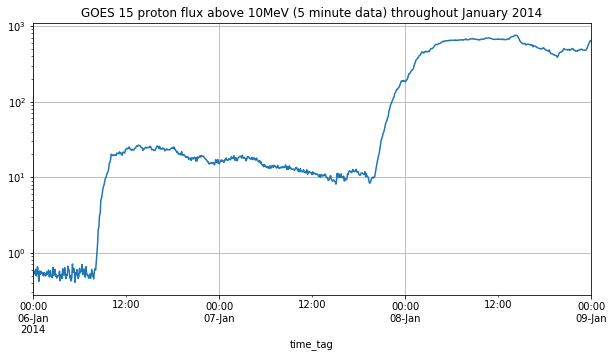

In [17]:
ax = dfEH['totflux'].loc[datetime(2014,1,6) : datetime(2014,1,9)].plot(grid=True, figsize=(10,5), logy=True, title='GOES '+str(NN)+' proton flux above 10MeV (5 minute data) throughout '+str(maxtime.strftime('%B %Y')))